## Importance analysis and first perforance baselines

## Encoding of all features

In this first iteration of design, we chose to simplify the model as much as possible. That includes dropping samples in case of doubt and not performing advanced feature engineering.\

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('SBAnational.csv')
df.head(1)

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_40262/2675700227.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SBAnational.csv')


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


In [4]:
drop_columns = ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank' ,'BankState', 'ApprovalDate', 'ApprovalFY',
                'CreateJob', 'RetainedJob','NoEmp', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
                'BalanceGross', 'ChgOffPrinGr']
df.drop(drop_columns, inplace=True, axis=1)
df.head(1)

,NAICS,Term,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,451120,84,2.0,1,0,N,Y,P I F,"$60,000.00","$48,000.00"


### Target

In [5]:
# Drop data with null MIS_Status, as it is useless
df.dropna(subset=['MIS_Status'], inplace=True)
df['MIS_Status'].describe()

count     897167
unique         2
top        P I F
freq      739609
Name: MIS_Status, dtype: object

In [6]:
target = 'PaidInFull'
# Encode the target variable to binary values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df['MIS_Status'])
df.drop(['MIS_Status'], inplace=True, axis=1)
print(df[target].describe())
# Paid in Full is encoded as 1

count    897167.000000
mean          0.824383
std           0.380494
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: PaidInFull, dtype: float64


In [7]:
df.columns

Index(['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv', 'SBA_Appv', 'PaidInFull'],
      dtype='object')

### NAICS

In [8]:
df['NAICS'] = df['NAICS'].astype(str)
def NAICS_conversion(naics_string):
    return int(naics_string[:2])

df['NAICS_i'] = df['NAICS'].apply(NAICS_conversion).astype(int)

In [9]:
df['NAICS_i'] = df['NAICS_i'].replace(0, 1)

In [10]:
df['NAICS_i'].value_counts().head(5)

NAICS_i
1     201667
44     84567
81     72395
54     67922
72     67511
Name: count, dtype: int64

In [11]:
features = ['NAICS_i']

### Term

In [12]:
# Term gets directly used as a numerical feature.
features.append('Term')

### NewExist

In [13]:
print(df['NewExist'].value_counts())

df = df[(df['NewExist'] != 0) & (df['NewExist'].notnull())]

print(df['NewExist'].value_counts())

NewExist
1.0    643446
2.0    252559
0.0      1028
Name: count, dtype: int64
NewExist
1.0    643446
2.0    252559
Name: count, dtype: int64


In [14]:
features.append('NewExist')

### FranchiseCode

In [15]:
# Function to create the 'isFranchise' column
def is_franchise(code):
    return 0 if code in [0, 1] else 1

df['isFranchise'] = df['FranchiseCode'].apply(is_franchise)

In [16]:
df['isFranchise'].value_counts()

isFranchise
0    844353
1     51652
Name: count, dtype: int64

In [17]:
features.append('isFranchise')

### UrbanRural

In [18]:
# UrbanRural will get encoded
features.append('UrbanRural')

### RevLineCr

In [19]:
df['RevLineCr'].value_counts()

RevLineCr
N    418229
0    257375
Y    200588
T     15232
1        22
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [20]:
df['RevLineCr'] = df['RevLineCr'].replace('N', '0')
df['RevLineCr'] = df['RevLineCr'].replace('0', 0)
df['RevLineCr'] = df['RevLineCr'].replace('Y', 1)

In [21]:
df = df[df['RevLineCr'].isin([0, 1])]

In [22]:
df['RevLineCr'].value_counts()

RevLineCr
0    675604
1    200588
Name: count, dtype: int64

In [23]:
features.append('RevLineCr')

### LowDoc

In [24]:
df['LowDoc'].value_counts()

LowDoc
N    762649
Y    107865
0      1238
C       752
S       599
A       491
R        73
1         1
Name: count, dtype: int64

In [25]:
df['LowDoc'] = df['LowDoc'].replace('N', 0)
df['LowDoc'] = df['LowDoc'].replace('Y', 1)

In [26]:
df = df[df['LowDoc'].isin([0, 1])]

In [27]:
df['LowDoc'] = df['LowDoc'].astype(int)

In [28]:
df['LowDoc'].describe()

count    870514.000000
mean          0.123910
std           0.329479
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LowDoc, dtype: float64

In [29]:
features.append('LowDoc')

### GrAppv

In [30]:
#Convert dollar values to float value
def dollar_to_float(dollar_string: str):
    return float(dollar_string.replace('$','').replace(',',''))

In [31]:
df['GrAppv'] = df['GrAppv'].apply(dollar_to_float)

In [32]:
df['GrAppv'].describe()

count    8.705140e+05
mean     1.951101e+05
std      2.843112e+05
min      1.000000e+03
25%      3.500000e+04
50%      9.400000e+04
75%      2.300000e+05
max      5.000000e+06
Name: GrAppv, dtype: float64

In [33]:
features.append('GrAppv')

### SBA_Appv (SBARatio)

In [34]:
# There is high colinearity between the three fields GrAppv, SBA_Appv and SBARatio, so there's no point in keeping all of them.
df['SBA_Appv'] = df['SBA_Appv'].apply(dollar_to_float)

In [35]:
df['SBARatio'] = df['SBA_Appv'] / df['GrAppv']

In [36]:
df['SBARatio'].describe()

count    870514.000000
mean          0.711526
std           0.173216
min           0.028140
25%           0.500000
50%           0.750000
75%           0.850000
max           1.000000
Name: SBARatio, dtype: float64

###

In [37]:
features.append('SBARatio')

In [38]:
df.describe()

,Term,NewExist,FranchiseCode,UrbanRural,LowDoc,GrAppv,SBA_Appv,PaidInFull,NAICS_i,isFranchise,SBARatio
count,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,8.705140e+05,8.705140e+05,870514.000000,870514.000000,870514.000000,870514.000000
mean,111.508946,1.282303,2794.073226,0.754880,0.123910,1.951101e+05,1.514752e+05,0.828538,39.741529,0.058415,0.711526
std,79.177488,0.450120,12847.026352,0.647823,0.329479,2.843112e+05,2.288713e+05,0.376912,26.025414,0.234526,0.173216
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000e+03,5.000000e+02,0.000000,1.000000,0.000000,0.028140
25%,60.000000,1.000000,1.000000,0.000000,0.000000,3.500000e+04,2.240000e+04,1.000000,23.000000,0.000000,0.500000
50%,84.000000,1.000000,1.000000,1.000000,0.000000,9.400000e+04,6.375000e+04,1.000000,44.000000,0.000000,0.750000
75%,120.000000,2.000000,1.000000,1.000000,0.000000,2.300000e+05,1.770000e+05,1.000000,56.000000,0.000000,0.850000
max,569.000000,2.000000,99999.000000,2.000000,1.000000,5.000000e+06,4.500000e+06,1.000000,92.000000,1.000000,1.000000


In [39]:
print(f'Our ratio of target variable is {df["PaidInFull"].mean()} ')

Our ratio of target variable is 0.8285380820986222 


## Decision trees for importance analysis

In [40]:
print(features)
print(target)

['NAICS_i', 'Term', 'NewExist', 'isFranchise', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBARatio']
PaidInFull


In [41]:
df[features]

,NAICS_i,Term,NewExist,isFranchise,UrbanRural,RevLineCr,LowDoc,GrAppv,SBARatio
0,45,84,2.0,0,0,0,1,60000.0,0.80
1,72,60,2.0,0,0,0,1,40000.0,0.80
2,62,180,1.0,0,0,0,0,287000.0,0.75
3,1,60,1.0,0,0,0,1,35000.0,0.80
4,1,240,1.0,0,0,0,0,229000.0,1.00
...,...,...,...,...,...,...,...,...,...
899159,45,60,1.0,0,0,0,0,70000.0,0.80
899160,45,60,1.0,0,0,1,0,85000.0,0.50
899161,33,108,1.0,0,0,0,0,300000.0,0.75
899162,1,60,1.0,0,0,0,1,75000.0,0.80


In [42]:
# Encode categorical features

cat_variables = [
    'NAICS_i',
    'UrbanRural'
]

df_encoded = pd.get_dummies(
    data = df,
    prefix = cat_variables,
    columns = cat_variables
)

df_encoded.head()

,NAICS,Term,NewExist,FranchiseCode,RevLineCr,LowDoc,GrAppv,SBA_Appv,PaidInFull,isFranchise,...,NAICS_i_56,NAICS_i_61,NAICS_i_62,NAICS_i_71,NAICS_i_72,NAICS_i_81,NAICS_i_92,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,451120,84,2.0,1,0,1,60000.0,48000.0,1,0,...,False,False,False,False,False,False,False,True,False,False
1,722410,60,2.0,1,0,1,40000.0,32000.0,1,0,...,False,False,False,False,True,False,False,True,False,False
2,621210,180,1.0,1,0,0,287000.0,215250.0,1,0,...,False,False,True,False,False,False,False,True,False,False
3,0,60,1.0,1,0,1,35000.0,28000.0,1,0,...,False,False,False,False,False,False,False,True,False,False
4,0,240,1.0,1,0,0,229000.0,229000.0,1,0,...,False,False,False,False,False,False,False,True,False,False


In [43]:
features = [feature for feature in df_encoded.columns if feature not in target]
print(features)

['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'isFranchise', 'SBARatio', 'NAICS_i_1', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_, y_train, y_ = train_test_split(df_encoded[features], df[target], train_size=.75)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

print(f"Train shape: {X_train.shape}, CV: {X_cv.shape}, test: {X_test.shape}")
print(f"Train shape: {y_train.shape}, CV: {y_cv.shape}, test: {y_test.shape}")

Train shape: (652885, 38), CV: (108814, 38), test: (108815, 38)
Train shape: (652885,), CV: (108814,), test: (108815,)


In [46]:
# Choose hyperparameter to be tried

min_samples_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depths_list = [1,2, 3, 4, 8, 16, 32, 64, None]

Optimum minimum samples to split is 200. CV Acc: 0.9372415314205893


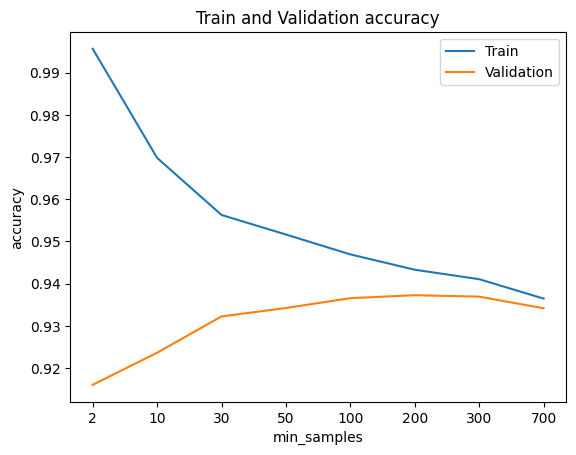

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

accuracies = {
    "train": [],
    "cv": []
}

for min_sample in min_samples_list:

    model = DecisionTreeClassifier(min_samples_split=min_sample).fit(X_train, y_train)

    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)

    accuracies["train"].append(accuracy_score(yhat_train, y_train))
    accuracies["cv"].append(accuracy_score(yhat_cv, y_cv))

optimum_min_samples = min_samples_list[np.argmax(accuracies['cv'])]
print(f"Optimum minimum samples to split is {optimum_min_samples}. CV Acc: {np.max(accuracies['cv'])}")

plt.title('Train and Validation accuracy')
plt.xlabel('min_samples')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_list )),labels=min_samples_list)
plt.plot(accuracies["train"])
plt.plot(accuracies["cv"])
plt.legend(['Train','Validation'])

Optimum maximum depth to stop is 16. CV Acc: 0.9350543128641535


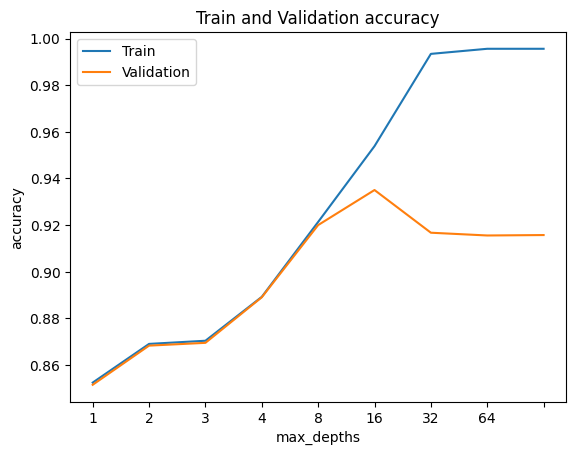

In [48]:
accuracies = {
    "train": [],
    "cv": []
}

for max_depth in max_depths_list:
    
    model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train)

    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)

    accuracies["train"].append(accuracy_score(yhat_train, y_train))
    accuracies["cv"].append(accuracy_score(yhat_cv, y_cv))

optimimum_max_depth = max_depths_list[np.argmax(accuracies['cv'])]

print(f"Optimum maximum depth to stop is {optimimum_max_depth}. CV Acc: {np.max(accuracies['cv'])}")

plt.title('Train and Validation accuracy')
plt.xlabel('max_depths')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depths_list )),labels=max_depths_list)
plt.plot(accuracies["train"])
plt.plot(accuracies["cv"])
plt.legend(['Train','Validation'])


In [49]:
decision_tree_model = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train, y_train)

In [79]:
# Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {
        "min_samples_split": [50, 100],
        "max_depth": [20, 30, 40],
        "n_estimators": [100, 200]
    }
]

# Let's also try some CV

from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features], df_encoded[target], train_size = .9)
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

search = HalvingGridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring='precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

# X_train, X_test, y_train, y_test = train_test_split(df_encoded[features], df_encoded[target], train_size = .9)
# from sklearn.model_selection import RepeatedStratifiedKFold
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3)

# search = GridSearchCV(estimator=RandomForestClassifier(), 
#                       param_grid=param_grid, 
#                       scoring='accuracy', 
#                       cv=cv,
#                       n_jobs=-1)
# search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 87051
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 87051
Fitting 9 folds for each of 12 candidates, totalling 108 fits
----------
iter: 1
n_candidates: 4
n_resources: 261153
Fitting 9 folds for each of 4 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 2
n_resources: 783459
Fitting 9 folds for each of 2 candidates, totalling 18 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42),
                    estimator=RandomForestClassifier(), n_jobs=-1,
                    param_grid=[{'max_depth': [20, 30, 40],
                                 'min_samples_split': [50, 100],
                                 'n_estimators': [100, 200]}],
                    scoring='precision', verbose=1)

In [80]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
40_50_200,"{'max_depth': 40, 'min_samples_split': 50, 'n_...",1,0.945586,0.000412
30_50_200,"{'max_depth': 30, 'min_samples_split': 50, 'n_...",2,0.945447,0.000452
40_50_200,"{'max_depth': 40, 'min_samples_split': 50, 'n_...",3,0.939630,0.001004
30_50_200,"{'max_depth': 30, 'min_samples_split': 50, 'n_...",4,0.939498,0.000886
40_50_100,"{'max_depth': 40, 'min_samples_split': 50, 'n_...",5,0.939310,0.000828
30_50_100,"{'max_depth': 30, 'min_samples_split': 50, 'n_...",6,0.939298,0.000688
30_50_200,"{'max_depth': 30, 'min_samples_split': 50, 'n_...",7,0.932294,0.000782
30_50_100,"{'max_depth': 30, 'min_samples_split': 50, 'n_...",8,0.932272,0.001354
40_50_100,"{'max_depth': 40, 'min_samples_split': 50, 'n_...",9,0.932092,0.001720


In [81]:
yhat_test = search.best_estimator_.predict(X_test)
print(y_test.shape)
print(accuracy_score(yhat_test, y_test))

(87052,)
0.9315466617653816


In [82]:
len(df[df[target] == 1])/len(df)

0.8285380820986222

In [83]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, yhat_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10968  3952]
 [ 2007 70125]]


In [84]:
yhat_train = search.best_estimator_.predict(X_train)

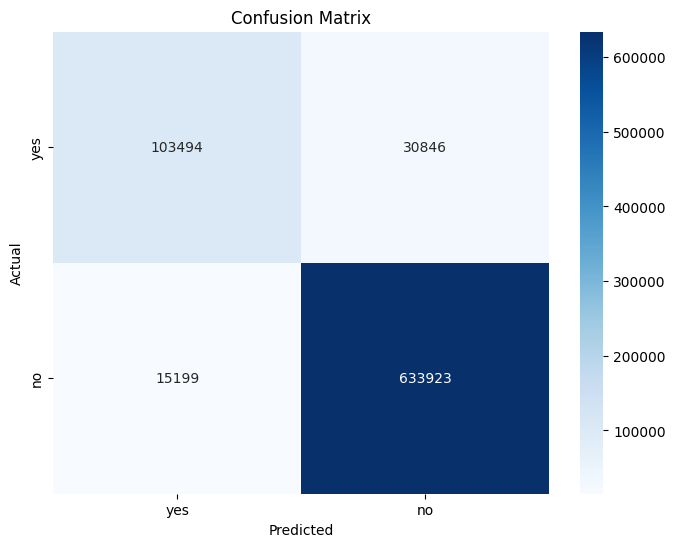

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_train, yhat_train)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['yes', 'no'], yticklabels=['yes', 'no'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [87]:
# I am sure that more estimators is generating better results.

rfmodel = RandomForestClassifier(
    n_estimators=500,
    max_depth=50,
    min_samples_split=50,
    n_jobs=-1,
    verbose=1
).fit(df_encoded[features], df_encoded[target])

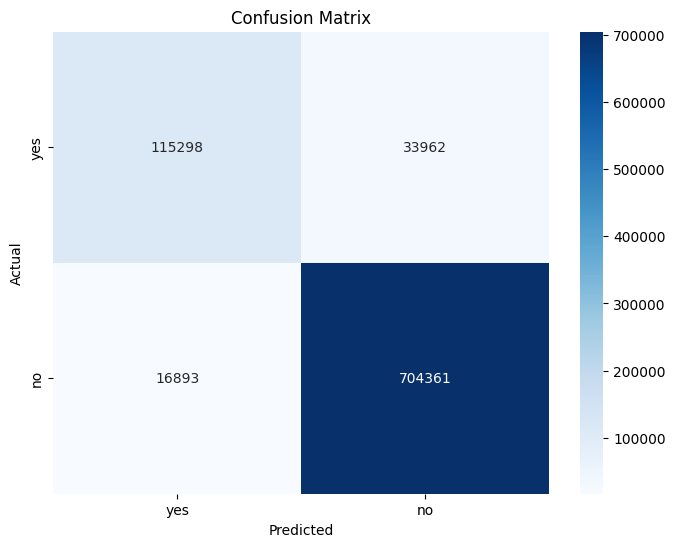

In [88]:
# Calculate the confusion matrix
yhat_rf = rfmodel.predict(df_encoded[features])
cm = confusion_matrix(df_encoded[target], yhat_rf)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['yes', 'no'], yticklabels=['yes', 'no'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [89]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

xgb_model.fit(df_encoded[features], df_encoded[target])

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:NAICS: object, RevLineCr: object